In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
import xgboost as xgb


In [2]:
df = pd.read_csv("train.csv", index_col='id')
test = pd.read_csv("test.csv", index_col='id')

categorical_features = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
numerical_features = df.select_dtypes(include=['number']).columns

In [3]:
# fix seed

def seed_everything(seed=0):
    #random.seed(seed)
    #os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

SEED = 42
seed_everything(SEED)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58645 entries, 0 to 58644
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  58645 non-null  int64  
 1   person_income               58645 non-null  int64  
 2   person_home_ownership       58645 non-null  object 
 3   person_emp_length           58645 non-null  float64
 4   loan_intent                 58645 non-null  object 
 5   loan_grade                  58645 non-null  object 
 6   loan_amnt                   58645 non-null  int64  
 7   loan_int_rate               58645 non-null  float64
 8   loan_percent_income         58645 non-null  float64
 9   cb_person_default_on_file   58645 non-null  object 
 10  cb_person_cred_hist_length  58645 non-null  int64  
 11  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 5.8+ MB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39098 entries, 58645 to 97742
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  39098 non-null  int64  
 1   person_income               39098 non-null  int64  
 2   person_home_ownership       39098 non-null  object 
 3   person_emp_length           39098 non-null  float64
 4   loan_intent                 39098 non-null  object 
 5   loan_grade                  39098 non-null  object 
 6   loan_amnt                   39098 non-null  int64  
 7   loan_int_rate               39098 non-null  float64
 8   loan_percent_income         39098 non-null  float64
 9   cb_person_default_on_file   39098 non-null  object 
 10  cb_person_cred_hist_length  39098 non-null  int64  
dtypes: float64(3), int64(4), object(4)
memory usage: 3.6+ MB


In [6]:
#정규화 X 범주형 데이터 변환 X

# 범주형 변수를 'category' 타입으로 변환
categorical_features = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
df[categorical_features] = df[categorical_features].astype('category')

# XGBoost 모델 훈련 시 enable_categorical=True 설정
X = df.drop('loan_status', axis=1)
y = df['loan_status']

X_train_origin, X_test_origin, y_train_origin, y_test_origin = train_test_split(X, y, test_size=0.25, random_state=42)

In [16]:
#정규화만 진행
X = df[numerical_features].drop('loan_status', axis=1)
y = df['loan_status']

X_train, X_test, y_train_final, y_test_final = train_test_split(X, y, test_size=0.25, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 범주형 변수를 'category' 타입으로 변환
categorical_data  = df[categorical_features].astype('category')

# 숫자형 데이터 정규화된 결과를 DataFrame으로 변환
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

# 정규화된 숫자형 데이터에 범주형 데이터 병합
X_train_final = pd.concat([X_train_scaled_df, categorical_data.loc[X_train.index]], axis=1)
X_test_final = pd.concat([X_test_scaled_df, categorical_data.loc[X_test.index]], axis=1)

In [8]:
# 범주형 처리 추가 / 정규화 X 
df_encoded = pd.get_dummies(df, columns=['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file'])
df_encoded

X = df_encoded.drop('loan_status', axis=1)
y = df_encoded['loan_status']

X_train_encoded, X_test_encoded, y_train_encoded, y_test_encoded = train_test_split(X, y, test_size=0.25, random_state=42)

In [17]:
# 범주형 처리 추가 / 정규화 O
df_encoded = pd.get_dummies(df, columns=['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file'])
df_encoded = df_encoded[df_encoded['person_income'] < 500000]

X = df_encoded.drop('loan_status', axis=1)
y = df_encoded['loan_status']

X_train, X_test, y_train_scaled, y_test_scaled = train_test_split(X, y, test_size=0.25, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [18]:
lr = LogisticRegression(max_iter=100, random_state=SEED)
lr.fit(X_train_scaled, y_train_scaled)

LogisticRegression(random_state=42)

In [9]:
#이상치 미제거 점수
y_pred=lr.predict(X_test_scaled)
print("roc auc:", roc_auc_score(y_test_scaled, y_pred))
print(classification_report(y_test_scaled, y_pred))

roc auc: 0.7495523048508249
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     12613
           1       0.77      0.52      0.62      2049

    accuracy                           0.91     14662
   macro avg       0.85      0.75      0.79     14662
weighted avg       0.91      0.91      0.90     14662



In [19]:
#이상치 제거 후 점수
y_pred=lr.predict(X_test_scaled)
print("roc auc:", roc_auc_score(y_test_scaled, y_pred))
print(classification_report(y_test_scaled, y_pred))

roc auc: 0.7646233855746398
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     12631
           1       0.77      0.56      0.65      2023

    accuracy                           0.92     14654
   macro avg       0.85      0.76      0.80     14654
weighted avg       0.91      0.92      0.91     14654



RandomForestRegressor

In [6]:
# RF 해보기
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=1000)
rf.fit(X_train_scaled, y_train_scaled)
y_pred = rf.predict(X_test_scaled)
print("Accuracy score (RF):", accuracy_score(y_test_scaled, y_pred.round()))

KeyboardInterrupt: 

SVM

In [ ]:
print("roc_auc_score (XGBoost):", roc_auc_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

In [11]:
from sklearn.svm import SVC

df_encoded = pd.get_dummies(df, columns=['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file'])

X = df_encoded.drop('loan_status', axis=1)
y = df_encoded['loan_status']

# 스케일링 적용
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svm_model = SVC(kernel='rbf')
svm_model.fit(X_train_scaled, y_train_scaled)

y_pred_svm = svm_model.predict(X_test_scaled)
print("Accuracy score (SVM):", accuracy_score(y_test_scaled, y_pred_svm.round()))

Accuracy score (RF): 0.9434592824989769


Gradient Boosting

In [21]:
xgb_model = xgb.XGBClassifier(eval_metric='logloss', enable_categorical=True, random_state=55)
xgb_model.fit(X_train_origin, y_train_origin)

# 예측 및 평가
y_pred = xgb_model.predict(X_test_origin)
print("Accuracy score (XGBoost):", accuracy_score(y_test_origin, y_pred))
print(classification_report(y_test_origin, y_pred))

Accuracy score (XGBoost): 0.9526667576046924
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     12613
           1       0.90      0.74      0.81      2049

    accuracy                           0.95     14662
   macro avg       0.93      0.86      0.89     14662
weighted avg       0.95      0.95      0.95     14662



In [13]:
xgb_model = xgb.XGBClassifier(eval_metric='logloss', random_state=55)
xgb_model.fit(X_train_scaled, y_train_scaled)

# 예측 및 평가
y_pred = xgb_model.predict(X_test_scaled)
print("accuracy_scoree (XGBoost):", accuracy_score(y_test_scaled, y_pred))

accuracy_scoree (XGBoost): 0.9522575364888828


In [17]:
xgb_model = xgb.XGBClassifier(eval_metric='logloss', enable_categorical=True, random_state=55)
xgb_model.fit(X_train_final, y_train_final)

# 예측 및 평가
y_pred = xgb_model.predict(X_test_final)
print("accuracy_score (XGBoost):", accuracy_score(y_test_final, y_pred))
print(classification_report(y_test_final, y_pred))

accuracy_score (XGBoost): 0.9526667576046924
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     12613
           1       0.90      0.74      0.81      2049

    accuracy                           0.95     14662
   macro avg       0.93      0.86      0.89     14662
weighted avg       0.95      0.95      0.95     14662



In [19]:
xgb_model = xgb.XGBClassifier(eval_metric='logloss' , enable_categorical=True, random_state=SEED)
xgb_model.fit(X_train_encoded, y_train_encoded)

# 예측 및 평가
y_pred = xgb_model.predict(X_test_encoded)
print("accuracy_score (XGBoost):", accuracy_score(y_test_encoded, y_pred))

accuracy_score (XGBoost): 0.9522575364888828


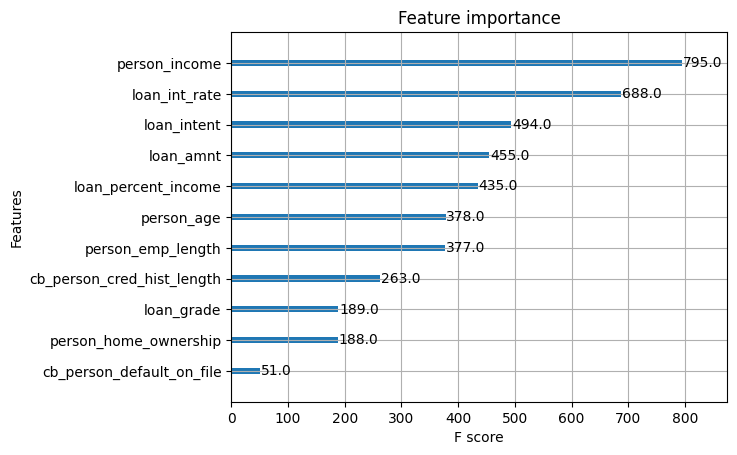

In [22]:
from xgboost import plot_importance

# 특성 중요도 시각화
plot_importance(xgb_model)
plt.show()

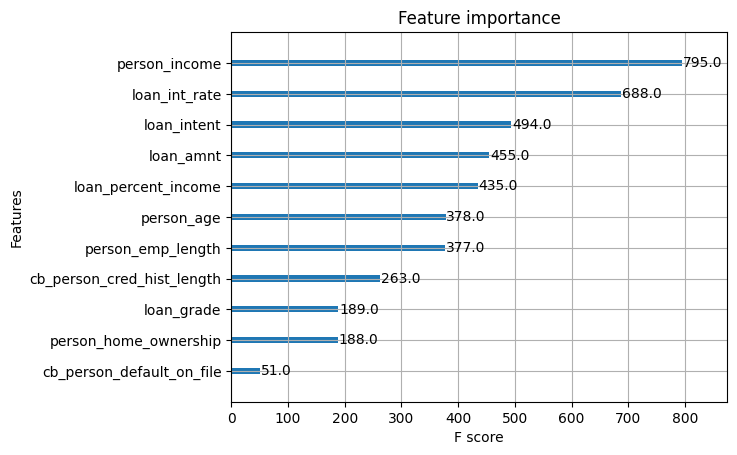

In [28]:
# 특성 중요도 시각화
plot_importance(xgb_model)
plt.show()

In [7]:
from catboost import CatBoostClassifier

# CatBoost 모델 생성 및 학습
catboost_model = CatBoostClassifier(logging_level='Silent', cat_features=categorical_features, random_state=55)
catboost_model.fit(X_train_origin, y_train_origin)

# 예측 및 평가
y_pred = catboost_model.predict(X_test_origin)
print("accuracy_score (XGBoost):", accuracy_score(y_test_origin, y_pred))
print(classification_report(y_test, y_pred))

accuracy_score (XGBoost): 0.953075978720502


NameError: name 'y_test' is not defined

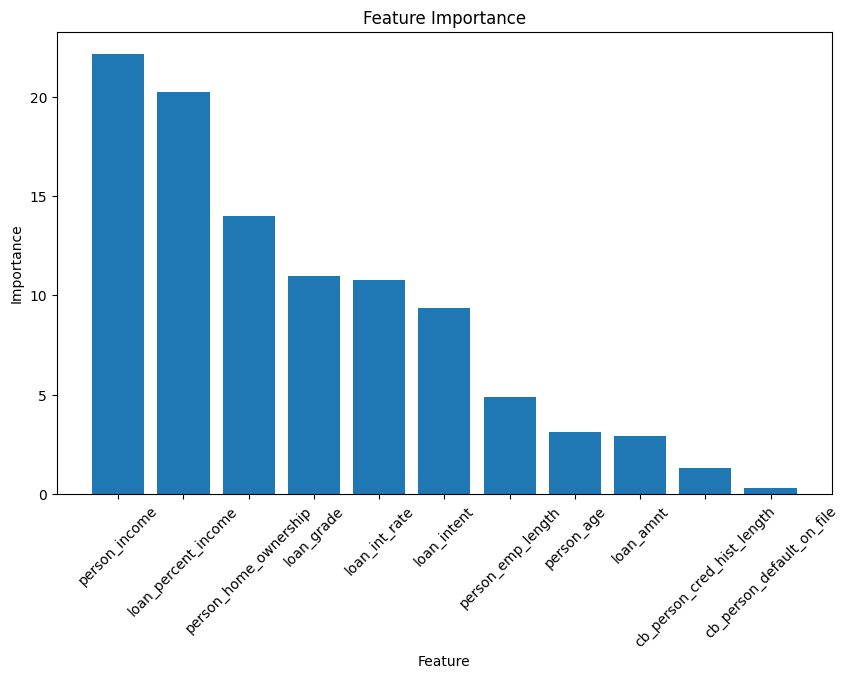

In [32]:
# 특성 중요도
feature_importance = catboost_model.get_feature_importance()

# 특성 이름
feature_names = X_train_origin.columns

feature_importance, feature_names = zip(*sorted(zip(feature_importance, feature_names), reverse=True))

# matplotlib으로 막대 그래프 시각화
plt.figure(figsize=(10, 6))
plt.bar(feature_names, feature_importance)
plt.title('Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.show()

In [40]:
df_added = df
df_added['loan_income_rate'] = round(df['loan_amnt'] / df['person_income'], 2)
df_added[['loan_percent_income', 'person_income', 'loan_amnt', 'loan_income_rate']].head()

,loan_percent_income,person_income,loan_amnt,loan_income_rate
id,,,,
0,0.17,35000,6000,0.17
1,0.07,56000,4000,0.07
2,0.21,28800,6000,0.21
3,0.17,70000,12000,0.17
4,0.10,60000,6000,0.10


In [41]:
df_added['total_loan'] = df_added['person_income'] * df_added['loan_percent_income']
df_added['different_loan'] = df_added['loan_percent_income'] - df_added['loan_income_rate']

In [46]:
df_added[df_added['different_loan'] != 0]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status,loan_income_rate,total_loan,different_loan
id,,,,,,,,,,,,,,,
7,21,20000,RENT,0.0,PERSONAL,C,2500,13.49,0.13,Y,3,0,0.12,2600.0,0.01
10,30,78000,MORTGAGE,5.0,VENTURE,B,12800,10.59,0.17,N,5,0,0.16,13260.0,0.01
15,29,33000,OWN,8.0,MEDICAL,A,7300,8.90,0.23,N,8,0,0.22,7590.0,0.01
32,30,80000,RENT,3.0,MEDICAL,B,6000,10.75,0.07,N,8,0,0.08,5600.0,-0.01
37,22,68000,MORTGAGE,7.0,PERSONAL,C,15900,13.49,0.25,N,2,0,0.23,17000.0,0.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58547,29,82500,RENT,5.0,EDUCATION,A,17000,7.66,0.22,N,5,0,0.21,18150.0,0.01
58561,33,36500,MORTGAGE,9.0,HOMEIMPROVEMENT,C,14000,11.03,0.39,N,5,0,0.38,14235.0,0.01
58609,40,43000,RENT,18.0,VENTURE,B,14400,11.71,0.34,N,12,1,0.33,14620.0,0.01


In [47]:
# XGBoost 모델 훈련 시 enable_categorical=True 설정
X = df_added.drop('loan_status', axis=1)
y = df_added['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=SEED)

In [49]:
xgb_model = xgb.XGBClassifier(eval_metric='logloss', enable_categorical=True, random_state=SEED)
xgb_model.fit(X_train, y_train)

# 예측 및 평가
y_pred = xgb_model.predict(X_test)
print("roc auc score (XGBoost):", roc_auc_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

roc auc score (XGBoost): 0.8629138125750246
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     12613
           1       0.90      0.74      0.81      2049

    accuracy                           0.95     14662
   macro avg       0.93      0.86      0.89     14662
weighted avg       0.95      0.95      0.95     14662



under sampling

In [24]:
df[df['loan_status'] == 1]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
id,,,,,,,,,,,,
11,22,33000,RENT,6.0,PERSONAL,B,10000,11.12,0.30,N,2,1
24,22,30000,RENT,3.0,MEDICAL,D,5000,16.49,0.17,N,4,1
25,25,25000,RENT,3.0,VENTURE,C,3500,13.49,0.14,Y,3,1
38,30,54000,RENT,0.0,MEDICAL,B,12500,11.71,0.24,N,10,1
39,22,32000,RENT,6.0,EDUCATION,D,8000,15.58,0.25,N,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...
58632,23,29654,RENT,1.0,VENTURE,A,10000,6.54,0.34,N,2,1
58635,32,69000,RENT,0.0,DEBTCONSOLIDATION,B,12000,10.20,0.17,N,7,1
58638,29,46610,MORTGAGE,1.0,PERSONAL,D,2600,17.58,0.05,N,6,1


In [92]:
df_zero = df[df['loan_status'] == 0]
df_zero['person_income'].max()

1900000

In [81]:
df_sampled = df[df['loan_status'] == 1]

In [93]:
# train 데이터를 train과 valid 데이터로 분할
X_1, X_2, y1, y2 = train_test_split(
    df_zero.drop("loan_status", axis=1),
    df_zero["loan_status"],
    test_size=0.7,
    shuffle=True, 
    random_state=SEED
)

In [94]:
X_new = pd.concat([X_1, df_sampled.drop('loan_status', axis=1)], ignore_index=True)
y_new = pd.concat([y1, df_sampled['loan_status']], ignore_index=True)

In [115]:
X_train, X_test, y_train, y_test = train_test_split(
    X_new, y_new,
    test_size=0.2,
    shuffle=True, 
    random_state=SEED
)

In [111]:
temp_df = X_train
temp_df['loan_status'] = y_train
temp_df = temp_df[temp_df['person_income'] < 400000]
X_train = temp_df.drop('loan_status', axis=1)
y_train = temp_df['loan_status']

In [112]:
xgb_model = xgb.XGBClassifier(enable_categorical=True, random_state=SEED)
xgb_model.fit(X_train, y_train)

# 예측 및 평가
y_pred = xgb_model.predict(X_test)

In [113]:
print("roc auc score (XGBoost):", roc_auc_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

roc auc score (XGBoost): 0.8769870587115997
              precision    recall  f1-score   support

           0       0.90      0.95      0.93      3067
           1       0.90      0.80      0.85      1621

    accuracy                           0.90      4688
   macro avg       0.90      0.88      0.89      4688
weighted avg       0.90      0.90      0.90      4688



In [100]:
print("roc auc score (XGBoost):", roc_auc_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

roc auc score (XGBoost): 0.8857293024167036
              precision    recall  f1-score   support

           0       0.91      0.95      0.93      3067
           1       0.90      0.82      0.86      1621

    accuracy                           0.91      4688
   macro avg       0.91      0.89      0.89      4688
weighted avg       0.91      0.91      0.91      4688



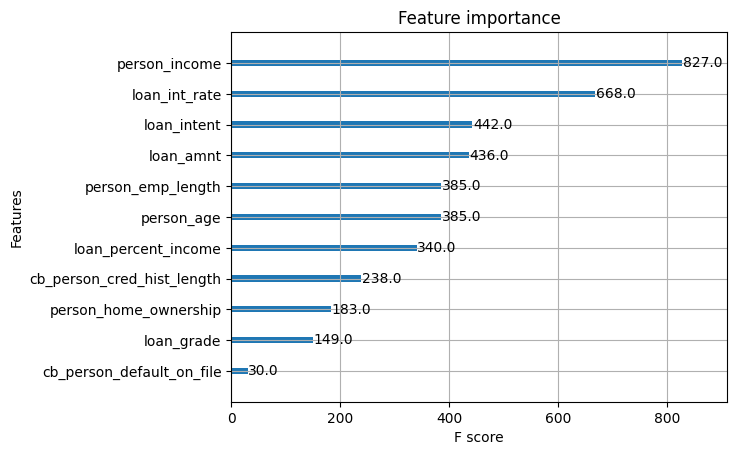

In [87]:
from xgboost import plot_importance
# 특성 중요도 시각화
plot_importance(xgb_model)
plt.show()

In [88]:
from catboost import CatBoostClassifier

# CatBoost 모델 생성 및 학습
catboost_model = CatBoostClassifier(logging_level='Silent', cat_features=categorical_features, random_state=55)
catboost_model.fit(X_train, y_train)

# 예측 및 평가
y_pred = catboost_model.predict(X_test)
print("roc auc score (XGBoost):", roc_auc_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

F1-score (CatBoost): 0.8560235063663075


In [ ]:
# 특성 중요도
feature_importance = catboost_model.get_feature_importance()

# 특성 이름
feature_names = X_train_origin.columns

feature_importance, feature_names = zip(*sorted(zip(feature_importance, feature_names), reverse=True))

# matplotlib으로 막대 그래프 시각화
plt.figure(figsize=(10, 6))
plt.bar(feature_names, feature_importance)
plt.title('Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.show()

Oversampling

In [66]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import xgboost as xgb

# 범주형 처리 추가 / 정규화 X 
#df_encoded = pd.get_dummies(df, columns=['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file'])

X = df_encoded.drop('loan_status', axis=1)
y = df_encoded['loan_status']

X_train_encoded, X_test_encoded, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# SMOTE를 사용하여 오버샘플링 수행
smote = SMOTE(random_state=SEED)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_encoded, y_train)

# XGBoost 모델 생성
xgb_model = xgb.XGBClassifier(enable_categorical=True, random_state=SEED)

# 최적의 모델
xgb_model.fit(X_train_resampled, y_train_resampled)

# 예측 및 평가
y_pred = xgb_model.predict(X_test_encoded)

# 평가 지표 출력
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred)}')
print(f'Recall: {recall_score(y_test, y_pred)}')
print(f'F1-score: {f1_score(y_test, y_pred)}')
print(f'AUC: {roc_auc_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))

Accuracy: 0.9525303505660893
Precision: 0.8986446670595168
Recall: 0.744265495363592
F1-score: 0.8142018152696209
AUC: 0.8653143856743433
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     12613
           1       0.90      0.74      0.81      2049

    accuracy                           0.95     14662
   macro avg       0.93      0.87      0.89     14662
weighted avg       0.95      0.95      0.95     14662



In [57]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.97      0.94      3067
           1       0.94      0.80      0.86      1621

    accuracy                           0.91      4688
   macro avg       0.92      0.88      0.90      4688
weighted avg       0.91      0.91      0.91      4688



In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTENC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import xgboost as xgb

# 범주형 처리 추가 / 정규화 X 
#df_encoded = pd.get_dummies(df, columns=['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file'])

X = df_encoded.drop('loan_status', axis=1)
y = df_encoded['loan_status']

X_train_encoded, X_test_encoded, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# SMOTE를 사용하여 오버샘플링 수행
smote = SMOTE(random_state=SEED)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_encoded, y_train)

# XGBoost 모델 생성
xgb_model = xgb.XGBClassifier(enable_categorical=True, random_state=SEED)

# 최적의 모델
xgb_model.fit(X_train_resampled, y_train_resampled)

# 예측 및 평가
y_pred = xgb_model.predict(X_test_encoded)

# 평가 지표 출력
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred)}')
print(f'Recall: {recall_score(y_test, y_pred)}')
print(f'F1-score: {f1_score(y_test, y_pred)}')
print(f'AUC: {roc_auc_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))

In [ ]:
test[categorical_features] = test[categorical_features].astype('category')
sub = xgb_model.predict(test)
sub = pd.DataFrame(sub)
sub.to_csv('gender_submission.csv',index = False)